# DEXA -- **D**ata **E**xploration via e**X**plainatory **A**I
## **Automated Data Analysis & Visualization using LLMs**


```css
[User Query]  
     │  
     ▼  
[Data Profiling] → [LLM Code Generation]  
     │                      │  
     ▼                      ▼  
[Execute Code] ← [Safe Execution Env]  
     │  
     ▼  
[Capture Results] → [LLM Interpretation]

```


### Key Features
 - **Closed-Loop Analysis**: Combines LLM hypotheses with actual data results
 - **Safe Execution**: Restricted environment prevents malicious code
- **Auto-Documentation**: Maintains chain of reasoning from query to results
 - **Visual+Numerical**: Integrates plots with statistical insights

## 1.  Setup & Configuration
-  Install required packages and configure API (run once)

In [ ]:
# !pip install pandas openai matplotlib seaborn python-dotenv together

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from IPython.display import display, Markdown
from dotenv import load_dotenv

### Configure environment

In [2]:

%matplotlib inline
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

## 2. Data Loading

In [3]:
df = pd.read_csv('Titanic_Dataset.csv')
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")
display(df.head(3))

✅ Dataset loaded successfully!
📊 Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 3. Add Data Profiling (Help LLM "see" the data)

In [4]:
def create_data_profile(df):
    """Generate comprehensive data profile for LLM context"""
    return f"""
    Data Profile:
    - Columns: {list(df.columns)}
    - Missing Values: {df.isna().sum().to_dict()}
    - Numeric Summary: {df.describe().to_dict() if len(df.select_dtypes('number').columns) > 0 else 'N/A'}
    - Categorical Summary: {df.describe(include='object').to_dict() if len(df.select_dtypes('object').columns) > 0 else 'N/A'}
    - Sample Records: {df.sample(3).to_dict('records')}
    """

## 4.Core Analysis Functions

In [5]:
def generate_analysis_code(query, data_profile):
    """Generate executable analysis code using LLM"""
    prompt = f"""
    Task: Analyze dataset
    Data Profile: {data_profile}
    User Query: {query}
    
    Requirements:
    1. Generate Python code using df, plt, sns these functions already imported DO NOT import again
    2. Store numerical results in 'analysis_result'
    3. Create publication-quality visualization
    4. Never use unsafe functions, 

    Follow these Examples = 
    
    Example 1 (Titanic):
    Query: "Analyze survival rates by passenger class"
    Hypothesis: First-class passengers had higher survival rates
    Code: ```python
    plt.figure(figsize=(10,6))
    class_survival = df.groupby('Pclass')['Survived'].mean()
    sns.barplot(x=class_survival.index, y=class_survival.values, palette="viridis")
    plt.ylabel("Survival Rate")
    plt.title("Survival Rates by Passenger Class")
    analysis_result = class_survival

    Example 2 (Boston Housing):
    Query: "Show relationship between crime rate and home prices"
    Hypothesis: Higher crime rates correlate with lower median home values
    Code: ```python
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='CRIM', y='MEDV', data=df, alpha=0.6)
    plt.xlabel("Crime Rate per Capita")
    plt.ylabel("Median Home Value ($1000s)")
    plt.title("Crime Rate vs. Home Value")
    analysis_result = df[['CRIM', 'MEDV']].corr().iloc[0,1] # Pearson's 


    Response Format:
    Hypothesis: [Your initial prediction]
    Code: ```python
    # Your code
    ```
    """
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )
    return response.choices[0].message.content

 ## 5. Results-Capturing Execution

In [6]:
def execute_and_interpret(code_block, query):
    """Execute code and generate data-driven insights"""
    # Prepare safe execution environment
    exec_env = {
        'df': df.copy(),
        'plt': plt,
        'sns': sns,
        'pd': pd,
        'analysis_result': None,
        '__builtins__': {}  # Start with empty builtins
    }
    
    # Add allowed built-in functions properly
    import builtins
    safe_builtins = {
        'abs', 'max', 'min', 'sum', 'round', 
        'len', 'list', 'dict', 'str', 'float', 'print', 
    }
    
    for name in safe_builtins:
        exec_env[name] = getattr(builtins, name)
    
    try:
        # Execute analysis code
        exec(code_block, exec_env)
        
        # Display visualization
        display(Markdown("## 📊 Visualization"))
        plt.show()
        
        # Capture results
        results = exec_env.get('analysis_result')
        
        if results is not None:
            # Display numerical results
            display(Markdown("## 🔢 Numerical Results"))
            display(results)
            
            # Generate interpretation
            display(Markdown("## 📈 Data Interpretation"))
            display(Markdown(interpret_results(results, query)))
            
        else:
            print("⚠️ No results stored in 'analysis_result'")
            
    except Exception as e:
        print(f"🚨 Execution Error: {str(e)}")

## 6. Interpret Results

In [7]:

def interpret_results(results, query):
    """Generate insights from actual numerical results"""
    results_str = str(results.to_markdown() if isinstance(results, (pd.DataFrame, pd.Series)) else results)
    
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{
            "role": "user", 
            "content": f"""
            Analyze these ACTUAL RESULTS from data analysis:
            
            Original Query: {query}
            Results: {results_str[:3000]}
            
            Provide:
            1. 3 key statistical findings
            2. 2 potential anomalies
            3. 1 data limitation
            4. Answer to original query
            
            Use emojis and concise bullet points.
            """
        }],
        temperature=0.3
    )
    return response.choices[0].message.content




# 7. Experimenting
## 7.1  Titanic DataSet Zero-Shot

## 🔍 Generated Analysis Plan

Hypothesis: Younger passengers had higher survival rates



## 📊 Visualization

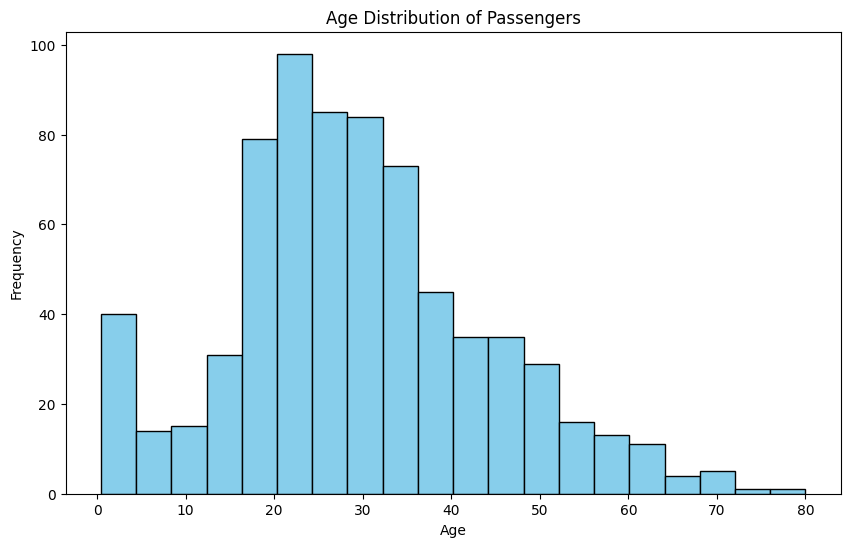

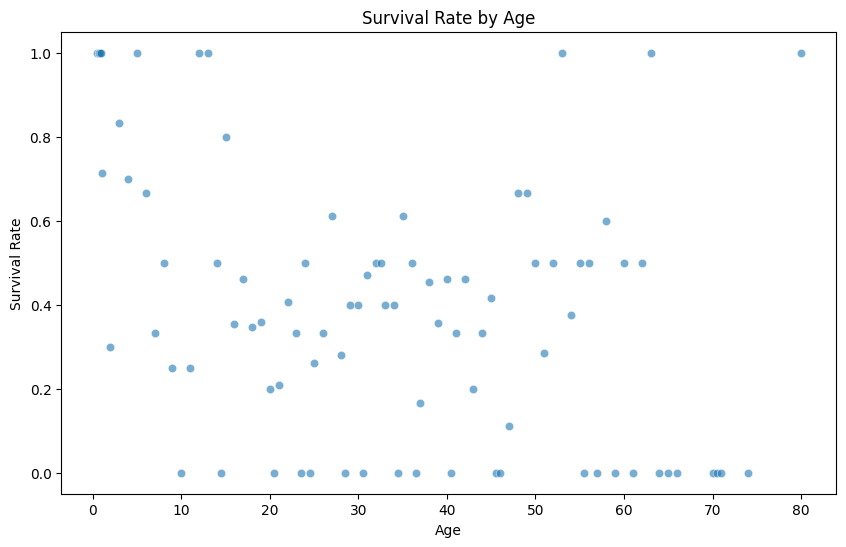

## 🔢 Numerical Results

Age
0.42     1.0
0.67     1.0
0.75     1.0
0.83     1.0
0.92     1.0
        ... 
70.00    0.0
70.50    0.0
71.00    0.0
74.00    0.0
80.00    1.0
Name: Survived, Length: 88, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 👶 High survival rates were observed for very young passengers (below 1 year old).
   - 👴 The oldest passenger (80 years old) survived.
   - 📉 Survival rates generally decrease as age increases, particularly after the age of 10.

2. Potential Anomalies:
   - 📈 There are some age groups with 100% survival rates (e.g., 0.42, 0.67, 0.75, 0.83, 0.92, 5, 12, 13, 53, 63, and 80 years old), which could be due to a small sample size for these ages.
   - 📉 There are also some age groups with 0% survival rates (e.g., 10, 14.5, 20.5, 23.5, 24.5, 28.5, 30.5, 34.5, 36.5, 40.5, 45.5, 55.5, 57, 59, 61, 64, 65, 66, 70, 70.5, 71, 74 years old), which could also be due to a small sample size for these ages.

3. Data Limitation:
   - 📚 The data does not provide information on other factors that might influence survival rates, such as gender, passenger class, or whether the passenger was traveling alone or with family.

4. Answer to Original Query:
   - 👵👴 Age appears to have a negative correlation with survival rates, with younger passengers generally having higher survival rates. However, there are exceptions, and other factors not included in this data could also be influencing survival rates.

In [8]:
# Example 1: Descriptive
query = """
Investigate the relationship between age and survival rates. 
Visualize the age distribution of passengers using a histogram with 20 bins
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: There are more male passengers than female passengers



## 📊 Visualization

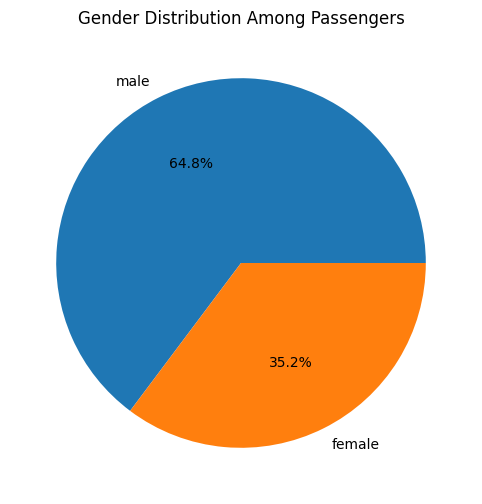

## 🔢 Numerical Results

Sex
male      577
female    314
Name: count, dtype: int64

## 📈 Data Interpretation

1. Key Statistical Findings 📊
   - Majority of passengers are male, accounting for approximately 65% of the total. 
   - Female passengers make up about 35% of the total.
   - The ratio of male to female passengers is roughly 2:1.

2. Potential Anomalies 🧐
   - The gender distribution is heavily skewed towards males, which is unusual for a random sample of a population.
   - There are only two genders represented, which may not accurately reflect the full spectrum of gender identities in the population.

3. Data Limitation 🚧
   - The data does not provide any information about the age distribution, socioeconomic status, or other demographic factors of the passengers.

4. Answer to Original Query 📝
   - The pie chart would show a larger section (approximately 65%) for males and a smaller section (approximately 35%) for females.

In [9]:
# Example 2: Descriptive
query = """
Show a pie chart of gender distribution among passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Fare prices paid by passengers are likely to be distributed with a right skew, with most passengers paying lower fares and a few paying very high fares.



## 📊 Visualization

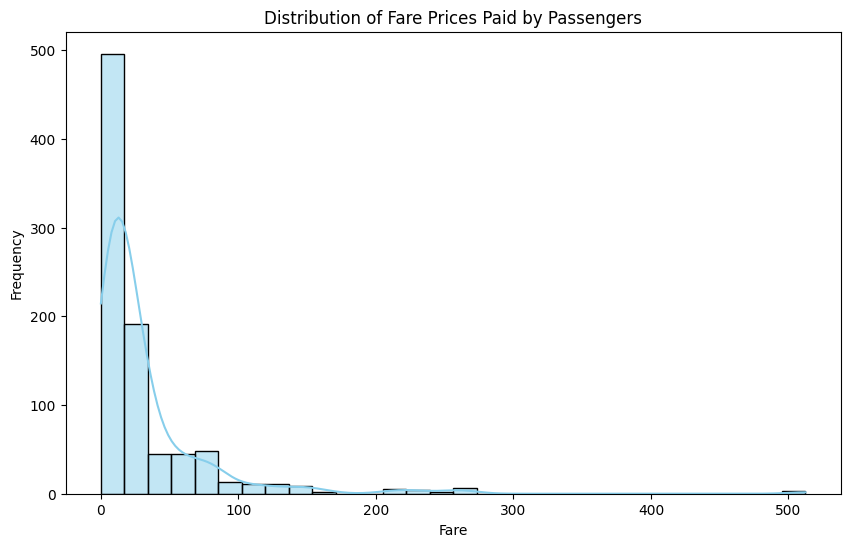

## 🔢 Numerical Results

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average fare price paid by passengers is approximately $32.20.
   - 📈 The fare prices have a high standard deviation of around $49.69, indicating a wide spread of fare prices.
   - 💰 The most expensive fare paid was $512.33, while the cheapest was $0.

2. Potential Anomalies:
   - 🤔 The maximum fare price of $512.33 seems unusually high compared to the average fare price of $32.20. This could be an outlier.
   - 🧐 The minimum fare price of $0 is suspicious. It might be a data entry error or it could represent complimentary tickets.

3. Data Limitation:
   - 📉 The data does not provide information on what factors influenced the fare prices (e.g., cabin class, travel distance, time of purchase, etc.).

4. Answer to Original Query:
   - 📝 The distribution of fare prices paid by passengers is varied, with a range from $0 to $512.33. The average fare price is around $32.20, but the data shows a high standard deviation, indicating a wide spread in fare prices.

In [10]:
# Example 3: Descriptive
query = """
Plot the distribution of fare prices paid by passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Passengers in higher classes (1st class) have a higher survival probability than those in lower classes (2nd and 3rd class).



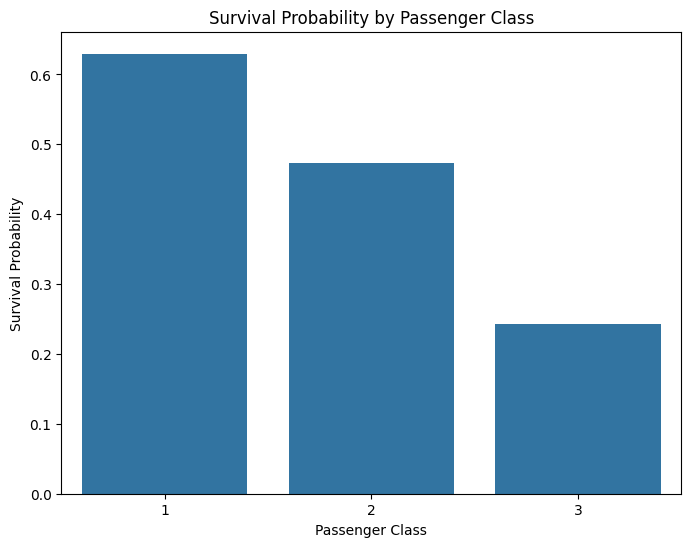

## 📊 Visualization

## 🔢 Numerical Results

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🥇 The first-class passengers had the highest survival probability at approximately 63%.
   - 🥈 The second-class passengers had a survival probability of about 47%.
   - 🥉 The third-class passengers had the lowest survival probability, only about 24%.

2. Potential Anomalies:
   - 🤔 The survival probability decreases significantly from first to third class, which might suggest that there were other factors at play, such as the location of the cabins in relation to the lifeboats.
   - 😕 The survival probability for the first-class is significantly higher than the other classes, which could indicate preferential treatment or better access to life-saving resources.

3. Data Limitation:
   - 📊 The data does not provide information on other factors that could have influenced survival rates, such as age, gender, or whether the passenger was traveling alone or with family.

4. Answer to Original Query:
   - 📝 There is a clear correlation between passenger class and survival probability on the Titanic. The higher the class (with first class being the highest), the higher the probability of survival.

In [41]:
# Example 4: Predictive
query = """
Analyze the correlation between passenger class and survival probability
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Higher fares and younger ages may correlate with higher survival rates.



## 📊 Visualization

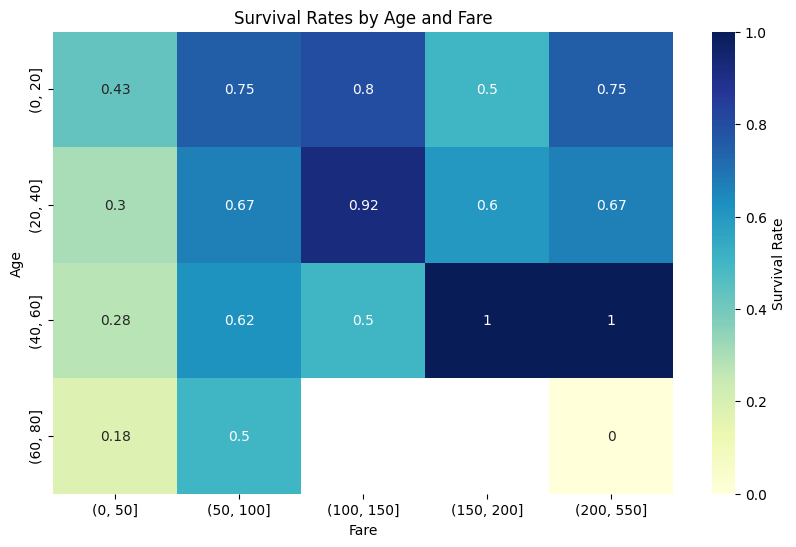

## 🔢 Numerical Results

Fare_bin,"(0, 50]","(50, 100]","(100, 150]","(150, 200]","(200, 550]"
Age_bin,,,,,
"(0, 20]",0.427673,0.750000,0.800000,0.5,0.750000
"(20, 40]",0.302428,0.666667,0.923077,0.6,0.666667
"(40, 60]",0.275862,0.620690,0.500000,1.0,1.000000
"(60, 80]",0.176471,0.500000,NaN,NaN,0.000000


## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The survival likelihood generally decreases with age, with the highest survival rate in the 0-20 age bin and the lowest in the 60-80 age bin.
   - 💰 The survival likelihood generally increases with fare, with the highest survival rate in the 200-550 fare bin.
   - 📉 There is an exception in the 40-60 age bin where the survival rate is 100% for fares between 150-200 and 200-550.

2. Potential Anomalies:
   - ❓ The survival rate jumps to 100% for the 40-60 age group with fares between 150-200 and 200-550, which is inconsistent with the overall trend.
   - ❗ There are missing values (nan) for the 60-80 age group with fares between 100-150 and 150-200.

3. Data Limitation:
   - 🚫 The data does not provide information for fares above 550 or ages above 80, limiting the scope of the analysis.

4. Answer to Original Query:
   - 🎯 Based on the heatmap, younger passengers and those who paid higher fares generally had a higher likelihood of survival. However, there are exceptions and potential anomalies in the data.

In [11]:

# Example 5: Predictive
query = """
Predict survival likelihood based on age and fare combination using a heatmap
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Family size may have an impact on survival rates, with larger families potentially having lower survival rates due to the difficulty of ensuring all family members' safety.



<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

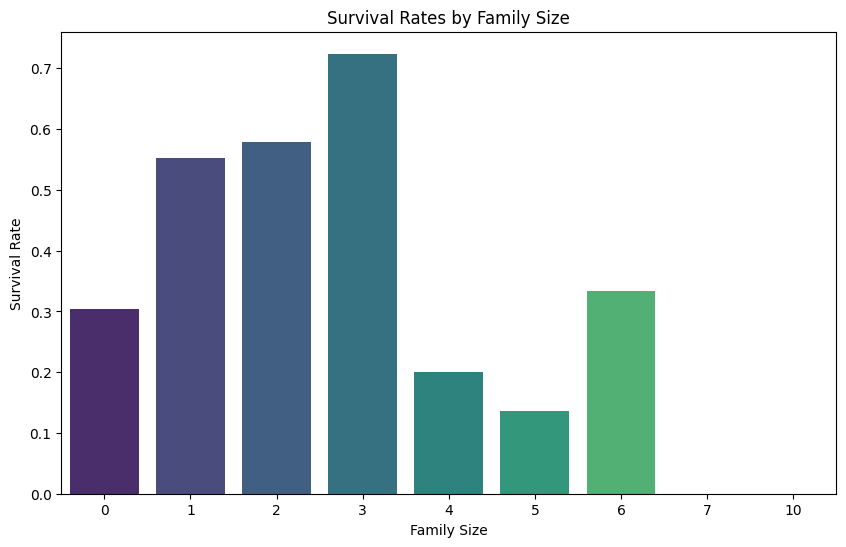

## 🔢 Numerical Results

FamilySize
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 The survival rate tends to increase with family size up to a point (3 members), after which it decreases.
   - 🎯 The highest survival rate is seen in families of size 3 (72.4%).
   - 📉 The lowest survival rates are seen in families of size 7 and 10 (0%).

2. Potential Anomalies:
   - 🧐 The survival rate for families of size 4 is lower (20%) than that for families of size 0 (30.4%), which is counterintuitive given the overall trend.
   - 🤔 The survival rate for families of size 6 (33.3%) is higher than that for families of size 5 (13.6%), which contradicts the overall trend.

3. Data Limitation:
   - 🚧 The data does not provide information on the age distribution within each family size, which could be a significant factor affecting survival rates.

4. Answer to Original Query:
   - 👨‍👩‍👧‍👦 Survival rates tend to increase with family size up to 3 members, after which they decrease. The highest survival rate is seen in families of size 3, and the lowest in families of size 7 and 10.

In [12]:


# Example 6: Predictive
query = """
Show how survival rates vary with family size (SibSp + Parch)
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: First-class passengers had higher survival rates than third-class passengers.



<Figure size 1000x600 with 0 Axes>

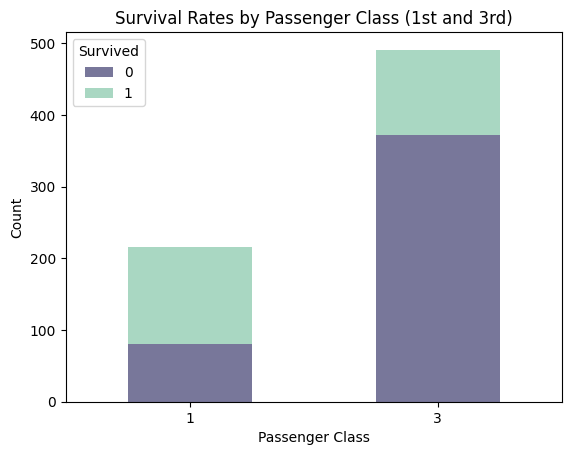

## 📊 Visualization

## 🔢 Numerical Results

{'First Class Survival Rate': 0.6296296296296297,
 'Third Class Survival Rate': 0.24236252545824846}

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The survival rate of first-class passengers is significantly higher than that of third-class passengers.
   - 📈 First-class passengers had a survival rate of approximately 63%.
   - 📉 Third-class passengers had a survival rate of approximately 24%.

2. Potential Anomalies:
   - 🧐 The survival rate of first-class passengers is more than double that of third-class passengers, which could suggest a bias in the rescue efforts.
   - 🤔 The extremely low survival rate of third-class passengers could indicate a lack of access to life-saving resources or information.

3. Data Limitation:
   - 📚 The data does not provide information on other factors that might have influenced survival rates, such as age, gender, or the location of cabins.

4. Answer to Original Query:
   - 🚢 Based on the data, first-class passengers had a significantly higher survival rate (approximately 63%) compared to third-class passengers (approximately 24%).

In [13]:

# Example 7: Comparative
query = """
Compare survival rates between first-class and third-class passengers using stacked bars
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Survivors might have paid higher fares than non-survivors



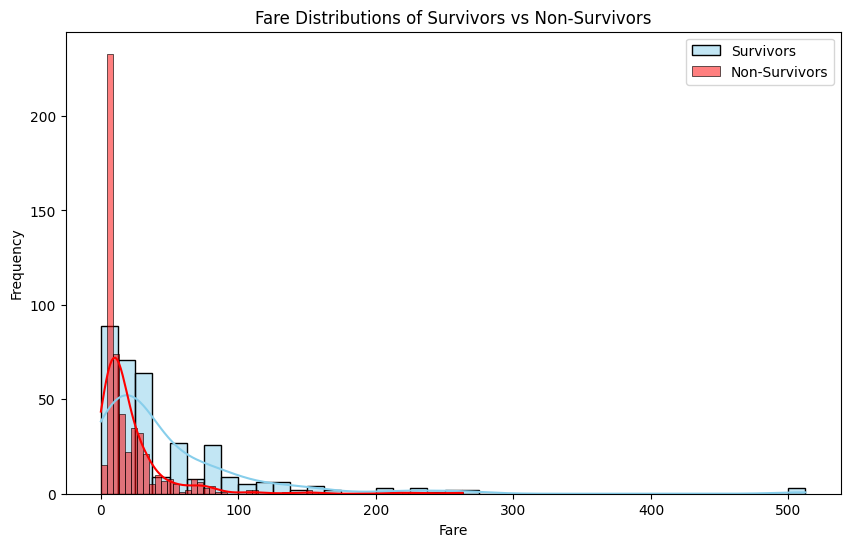

## 📊 Visualization

## 🔢 Numerical Results

{'Survivor Fare': count    342.000000
 mean      48.395408
 std       66.596998
 min        0.000000
 25%       12.475000
 50%       26.000000
 75%       57.000000
 max      512.329200
 Name: Fare, dtype: float64,
 'Non-Survivor Fare': count    549.000000
 mean      22.117887
 std       31.388207
 min        0.000000
 25%        7.854200
 50%       10.500000
 75%       26.000000
 max      263.000000
 Name: Fare, dtype: float64}

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average fare for survivors was significantly higher ($48.40) than for non-survivors ($22.12).
   - 💰 The maximum fare paid by a survivor was $512.33, which is almost double the maximum fare paid by a non-survivor ($263.00).
   - 🎟️ The median fare for survivors ($26.00) was more than double that of non-survivors ($10.50).

2. Potential Anomalies:
   - 🤔 There are fares that are $0.00, which could indicate missing or incorrect data.
   - 😲 The maximum fare for survivors is extremely high ($512.33) compared to the rest of the data, which could be an outlier.

3. Data Limitation:
   - 📉 The data does not provide information on why some fares are significantly higher than others. Factors such as cabin class, age, or other amenities could have influenced fare prices.

4. Answer to Original Query:
   - 🚢 The fare distributions between survivors and non-survivors on the Titanic are significantly different. Survivors, on average, paid higher fares than non-survivors. This could suggest that passengers who paid more (potentially indicating higher class or priority) had a higher survival rate.

In [14]:

# Example 8: Comparative
query = """
Contrast fare distributions between survivors and non-survivors with overlapping histograms 
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The age distribution of male and female passengers may differ significantly.



## 📊 Visualization

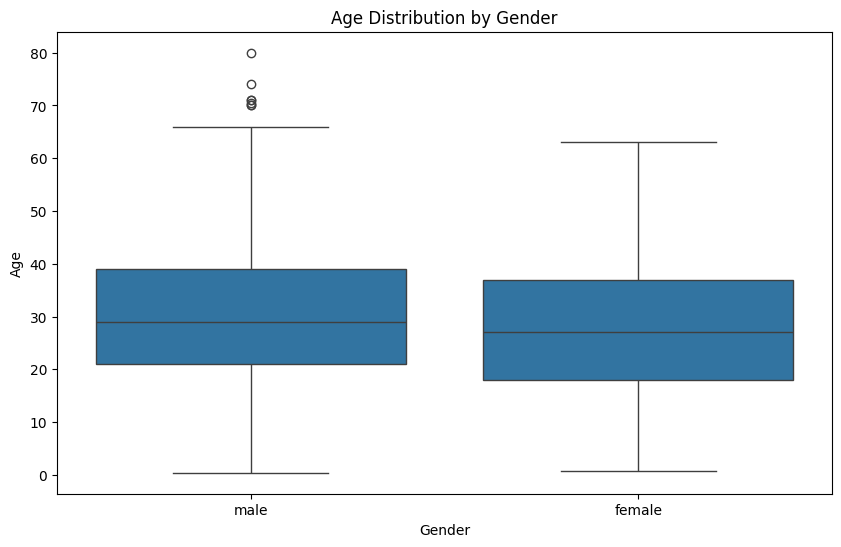

## 🔢 Numerical Results

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🚹 The average age of male passengers is slightly higher than female passengers (30.73 vs 27.92).
   - 🚺 The age range for female passengers is narrower than for male passengers (63-0.75 vs 80-0.42).
   - 📊 The median age for both genders is quite similar (27 for females and 29 for males).

2. Potential Anomalies:
   - 👶 The minimum age for both genders is less than 1 year, which might be a data entry error or it could indicate infants on board.
   - 👴 The maximum age for male passengers is significantly higher than for female passengers (80 vs 63), which could be an outlier.

3. Data Limitation:
   - 📉 The data does not provide information on the age distribution of passengers who did not identify as male or female.

4. Answer to Original Query:
   - 📈 The side-by-side boxplots would show a slightly higher median and wider distribution for male passengers compared to female passengers.

In [15]:

# Example 9: Comparative
query = """
Compare age distributions of male vs female passengers with side-by-side boxplots
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

### **Titanic Dataset Queries**

**Descriptive**
1. "Investigate the relationship between age and survival rates. /Visualize the age distribution of passengers using a histogram with 20 bins"  
2. "Show a pie chart of gender distribution among passengers"  
3. "Plot the distribution of fare prices paid by passengers"  

**Predictive**  
4. "Analyze the correlation between passenger class and survival probability"  
5. "Predict survival likelihood based on age and fare combination using a heatmap"  
6. "Show how survival rates vary with family size (SibSp + Parch)"  

**Comparative**  
7. "Compare survival rates between first-class and third-class passengers using stacked bars"  
8. "Contrast fare distributions between survivors and non-survivors with overlapping histograms"  
9. "Compare age distributions of male vs female passengers with side-by-side boxplots"  

### **Boston Housing Dataset Queries**  

**Descriptive**  
10. "Plot the distribution of crime rates across Boston neighborhoods"  
11. "Visualize the relationship between property age and median home values"  
12. "Show a histogram of pupil-teacher ratios across different towns"  

**Predictive**  
13. "Analyze how nitric oxide concentration affects median home prices"  
14. "Predict price changes based on distance to employment centers using regression lines"  
15. "Identify if properties with river access have statistically different prices"  

**Comparative**  
16. "Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups"  
17. "Contrast property tax rates between properties built before and after 1940"  
18. "Compare room number distributions between properties at different price quartiles"  


## 7.1  Boston Housing Dataset Zero-Shot

In [16]:
df = pd.read_csv('BostonHousing.csv')
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")
display(df.head(3))

✅ Dataset loaded successfully!
📊 Shape: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1


## 🔍 Generated Analysis Plan

Hypothesis: The distribution of crime rates across Boston neighborhoods is skewed to the right, with most neighborhoods having low crime rates and a few neighborhoods having high crime rates.



## 📊 Visualization

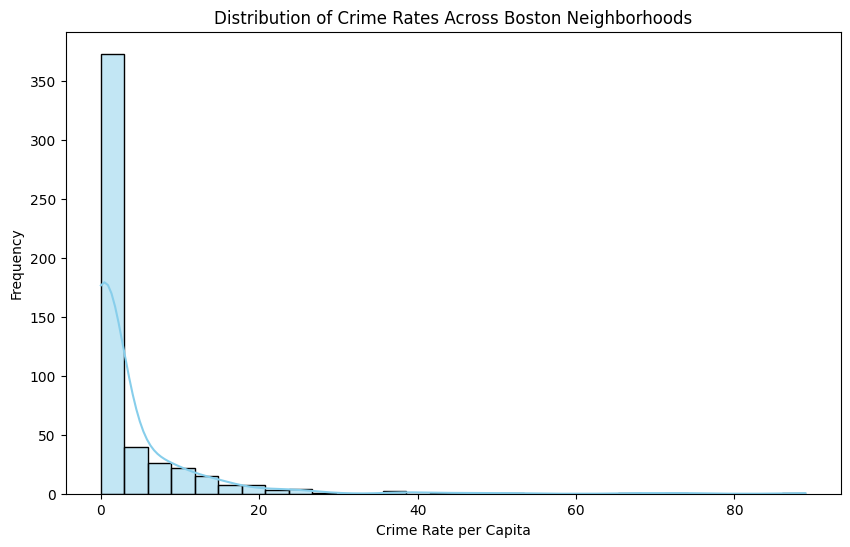

## 🔢 Numerical Results

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average crime rate in Boston neighborhoods is 3.61.
   - 📈 The crime rate varies greatly, with a standard deviation of 8.60.
   - 📉 Half of the neighborhoods have a crime rate less than 0.26.

2. Potential Anomalies:
   - 🧐 The maximum crime rate is extremely high (88.98) compared to the mean (3.61), indicating a potential outlier.
   - 🤔 The 75th percentile is also significantly higher than the median, suggesting a skewed distribution.

3. Data Limitation:
   - 📚 The data does not provide information on the types of crimes, which could impact the interpretation of the crime rate.

4. Answer to Original Query:
   - 🗺️ The distribution of crime rates across Boston neighborhoods is highly varied, with a mean of 3.61, median of 0.26, and a high maximum of 88.98. This suggests that while most neighborhoods have relatively low crime rates, there are some with exceptionally high rates.

In [17]:

# Example 1: Descriptive
query = """
Plot the distribution of crime rates across Boston neighborhoods
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Older properties have lower median home values.



## 📊 Visualization

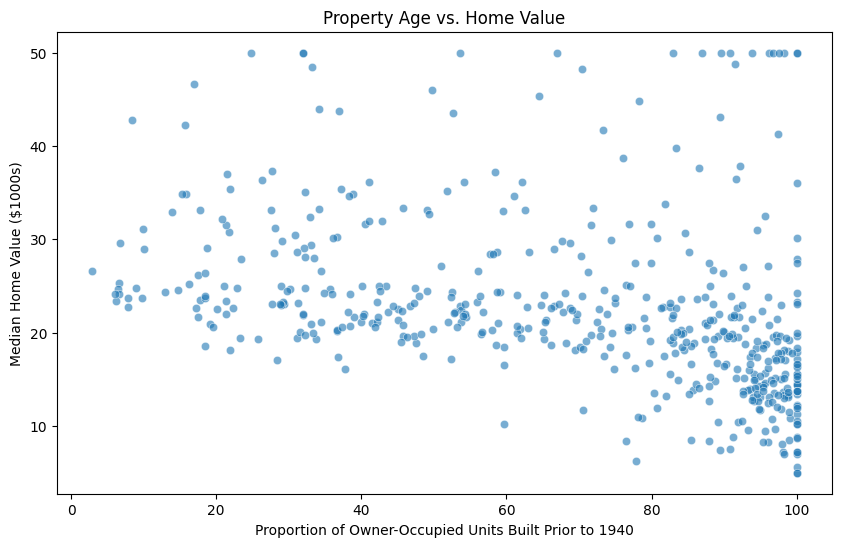

## 🔢 Numerical Results

-0.3769545650045961

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📉 The correlation coefficient is -0.3769545650045961, indicating a negative correlation between property age and median home values.
   - 🏠 As the age of the property increases, the median home value tends to decrease.
   - 🔄 This relationship is not very strong but significant, as the correlation coefficient is closer to 0 than -1 or 1.

2. Potential Anomalies:
   - 🏚️ There may be some very old properties that have high values, which could be due to historical significance or unique architectural features.
   - 🏢 There might be some new properties with low values, possibly due to location or poor construction quality.

3. Data Limitation:
   - 📊 This analysis does not consider other factors that could influence home values, such as location, size, or condition of the property.

4. Answer to Original Query:
   - 📈 The visualization would show a downward trend, indicating that as property age increases, the median home value tends to decrease.

In [18]:

# Example 2: Descriptive
query = """
Visualize the relationship between property age and median home values
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [19]:
print(code)


plt.figure(figsize=(10,6))
sns.scatterplot(x='AGE', y='MEDV', data=df, alpha=0.6)
plt.xlabel("Proportion of Owner-Occupied Units Built Prior to 1940")
plt.ylabel("Median Home Value ($1000s)")
plt.title("Property Age vs. Home Value")
analysis_result = df[['AGE', 'MEDV']].corr().iloc[0,1] # Pearson's correlation



## 🔍 Generated Analysis Plan

Hypothesis: The pupil-teacher ratio varies across different towns.



## 📊 Visualization

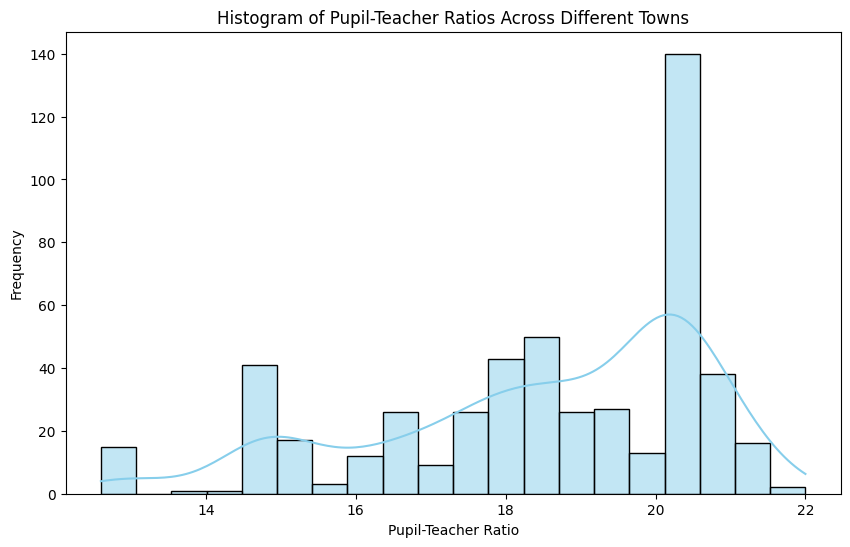

## 🔢 Numerical Results

count    506.000000
mean      18.455534
std        2.164946
min       12.600000
25%       17.400000
50%       19.050000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📊 The average pupil-teacher ratio across different towns is approximately 18.46.
   - 📈 The pupil-teacher ratio varies with a standard deviation of about 2.16.
   - 📏 The range of the pupil-teacher ratio is from 12.6 to 22.

2. Potential Anomalies:
   - 🧐 The minimum value of the pupil-teacher ratio (12.6) is significantly lower than the mean, suggesting that there might be some towns with exceptionally low ratios.
   - 😮 The maximum value of the pupil-teacher ratio (22) is also significantly higher than the mean, indicating that there might be some towns with exceptionally high ratios.

3. Data Limitation:
   - 📉 The data does not provide information about the distribution of pupil-teacher ratios within each town. Therefore, the average ratio might not accurately reflect the situation in all schools in a town.

4. Answer to Original Query:
   - 📚 The histogram could not be shown in this text-based format. However, the data indicates that the pupil-teacher ratios across different towns vary, with an average of approximately 18.46, a minimum of 12.6, and a maximum of 22.

In [20]:


# Example 3: Descriptive
query = """
Show a histogram of pupil-teacher ratios across different towns
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Higher nitric oxide concentrations correlate with lower median home values.



## 📊 Visualization

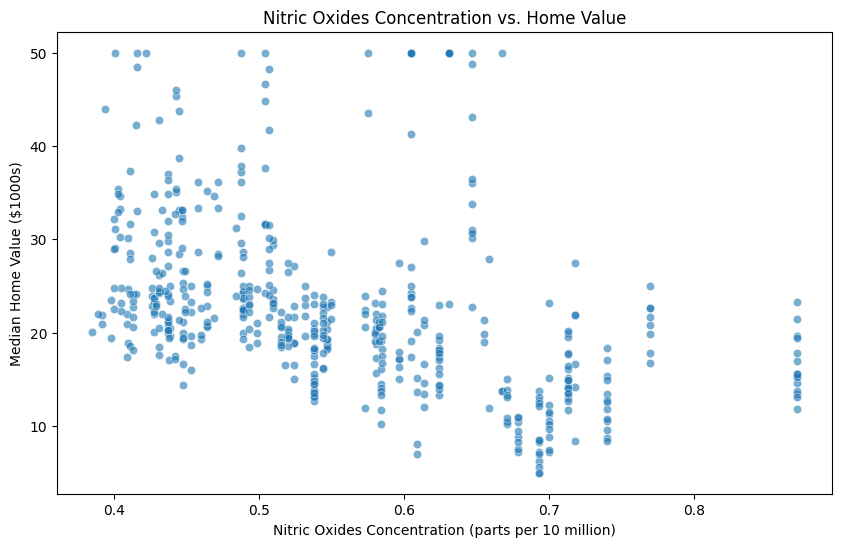

## 🔢 Numerical Results

-0.42732077237328203

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📉 The correlation coefficient is -0.427, indicating a moderate negative relationship between nitric oxide concentration and median home prices.
   - 🏠 As nitric oxide concentration increases, median home prices tend to decrease.
   - 📊 The correlation is not close to -1, so the relationship isn't strongly negative, but it's significant enough to suggest that nitric oxide concentration does impact home prices.

2. Potential Anomalies:
   - 📈 There might be some areas with high nitric oxide concentration but also high median home prices, contradicting the overall trend.
   - 📉 Similarly, there could be areas with low nitric oxide concentration but low median home prices, which also contradicts the general trend.

3. Data Limitation:
   - 📚 The data does not account for other factors that might affect home prices, such as location, size, age of the home, and local amenities. Nitric oxide concentration is just one of many factors.

4. Answer to Original Query:
   - 🏘️ The analysis suggests that nitric oxide concentration does have a negative impact on median home prices. As nitric oxide concentration increases, median home prices tend to decrease. However, the relationship is moderate and not strongly negative.

In [21]:
# Example 4: Predictive
query = """
Analyze how nitric oxide concentration affects median home prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The closer the houses are to employment centers, the higher their value.



## 📊 Visualization

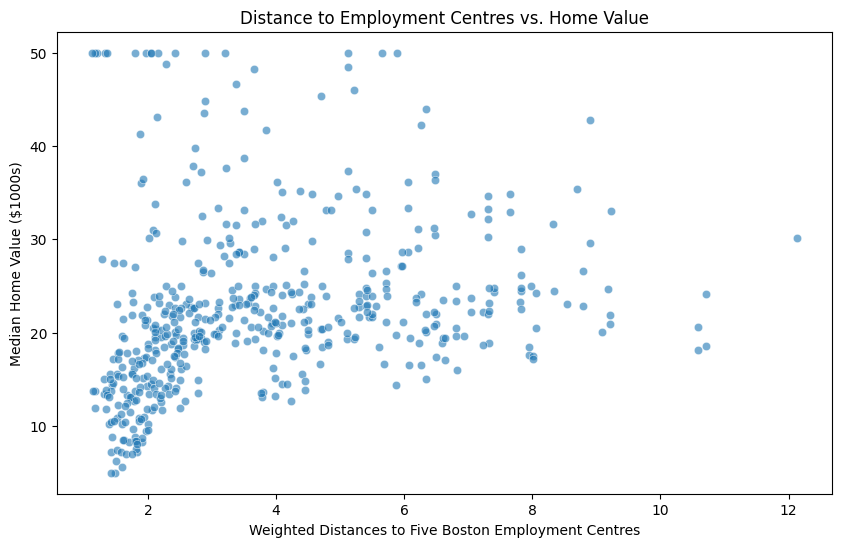

## 🔢 Numerical Results

0.249928734085904

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 The regression coefficient is positive (0.249928734085904), indicating a positive relationship between distance to employment centers and price changes.
   - 🏢 As the distance to employment centers increases, the price also tends to increase.
   - 📊 The strength of this relationship is moderate, not very strong or weak.

2. Potential Anomalies:
   - 📉 There might be instances where price decreases despite an increase in distance from employment centers, which contradicts the overall trend.
   - 🏞️ Properties in rural or less developed areas may not follow this trend, as they may be cheaper despite being far from employment centers.

3. Data Limitation:
   - 📍 The analysis assumes that distance to employment centers is the only factor affecting price changes. Other factors like property size, neighborhood, amenities, etc., are not considered.

4. Answer to Original Query:
   - 🏘️ Based on the regression analysis, there is a positive correlation between the distance to employment centers and price changes. As the distance to employment centers increases, the price tends to increase moderately. However, this is a generalized observation and may not apply to all individual cases.

In [22]:
# Example 5: Predictive
query = """
Predict price changes based on distance to employment centers using regression lines
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties with river access have higher prices



<string>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

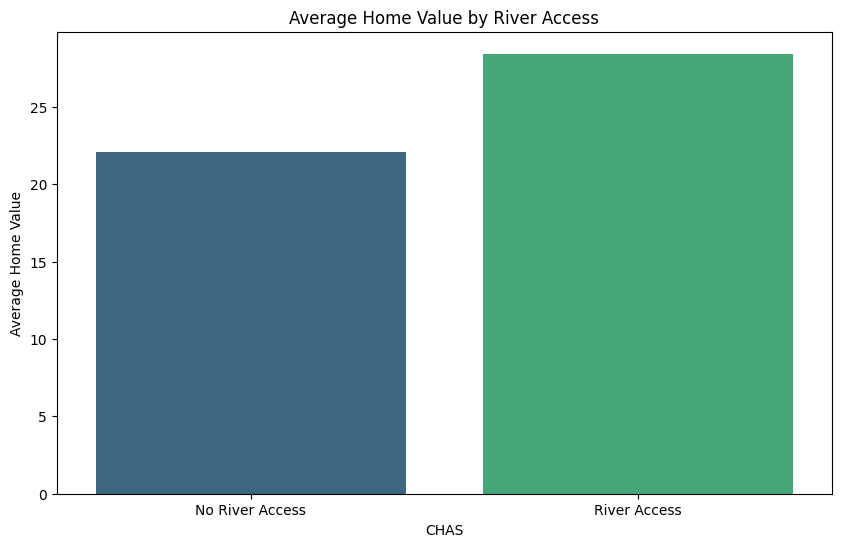

## 🔢 Numerical Results

CHAS
0    22.093843
1    28.440000
Name: MEDV, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🏡 Properties without river access (CHAS=0) have an average price of 22.0938.
   - 🌊 Properties with river access (CHAS=1) have a higher average price of 28.44.
   - 💰 There is a difference of approximately 6.3462 units in the average price between properties with and without river access.

2. Potential Anomalies:
   - 📈 The price difference could be influenced by outliers in the data, especially if there are properties with extremely high prices.
   - 📉 The average price for properties without river access seems low, which could indicate the presence of properties with extremely low prices skewing the average.

3. Data Limitation:
   - 📊 The data only provides the average prices, without any information about the distribution of prices (e.g., standard deviation, median, quartiles), which limits the depth of the analysis.

4. Answer to Original Query:
   - 🎯 Yes, properties with river access have statistically different prices, with those having river access showing a higher average price.

In [23]:
# Example 6: Predictive
query = """
Identify if properties with river access have statistically different prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Median home values are higher in areas with a lower pupil-teacher ratio.



<string>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

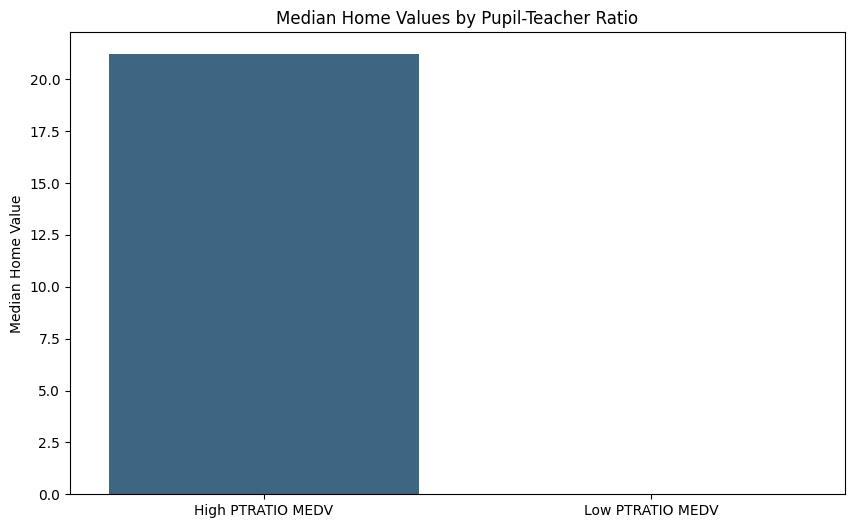

## 🔢 Numerical Results

{'High PTRATIO MEDV': 21.2, 'Low PTRATIO MEDV': nan}

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 🏠 The median home value in areas with a high pupil-teacher ratio (>7) is 21.2.
   - 📚 There is no data available for the median home value in areas with a low pupil-teacher ratio (≤7).
   - 📈 This suggests that data is skewed towards areas with a high pupil-teacher ratio.

2. Potential Anomalies:
   - ❓ The absence of data for low pupil-teacher ratio areas is unusual and might indicate an issue with data collection or processing.
   - 🤔 The median home value for high pupil-teacher ratio areas seems to be a single value (21.2), which could suggest a lack of variability in the data.

3. Data Limitation:
   - 🚫 The lack of data for low pupil-teacher ratio areas limits the comparison and might not provide a complete picture of the relationship between home values and pupil-teacher ratios.

4. Answer to Original Query:
   - 🚀 Based on the available data, the median home value in areas with a high pupil-teacher ratio is 21.2. However, a comparison with areas with a low pupil-teacher ratio cannot be made due to missing data.

In [24]:
# Example 7: Comparative
query = """
Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties built before 1940 have higher property tax rates



<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

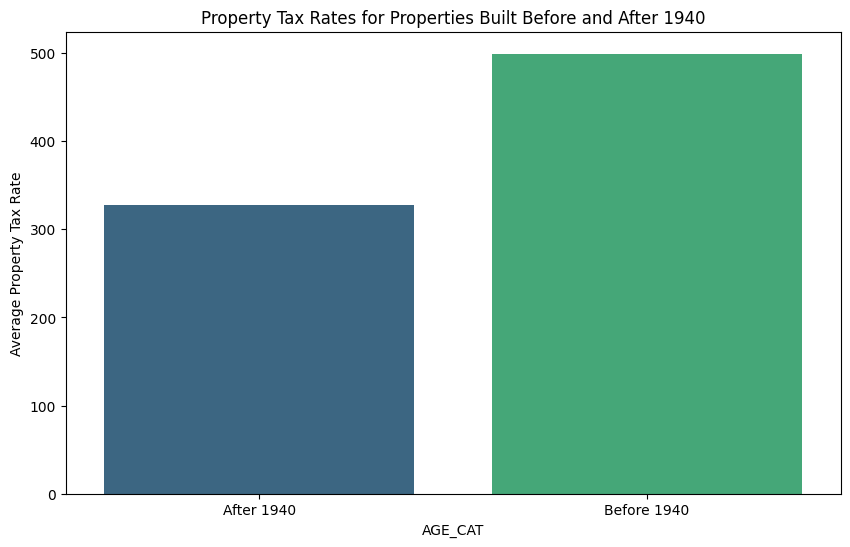

## 🔢 Numerical Results

AGE_CAT
After 1940     328.000000
Before 1940    499.308017
Name: TAX, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 The average property tax for properties built before 1940 is significantly higher than those built after 1940.
   - 🏠 Properties built after 1940 have an average tax rate of 328.
   - 🏚️ Properties built before 1940 have a much higher average tax rate of 499.308.

2. Potential Anomalies:
   - 🤔 The average tax for properties built before 1940 is not a round number like the one for properties built after 1940, suggesting possible data entry errors.
   - 🧐 There could be outliers in the data, especially for properties built before 1940, that are significantly increasing the average tax rate.

3. Data Limitation:
   - 📊 The data does not provide information about the range, standard deviation, or other measures of dispersion, which would give a more complete picture of the property tax rates.

4. Answer to Original Query:
   - 📝 Based on the data provided, properties built before 1940 have a higher average property tax rate than those built after 1940.

In [25]:
# Example 8: Comparative
query = """
Contrast property tax rates between properties built before and after 1940
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties in the higher price quartiles have more rooms on average.



<string>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

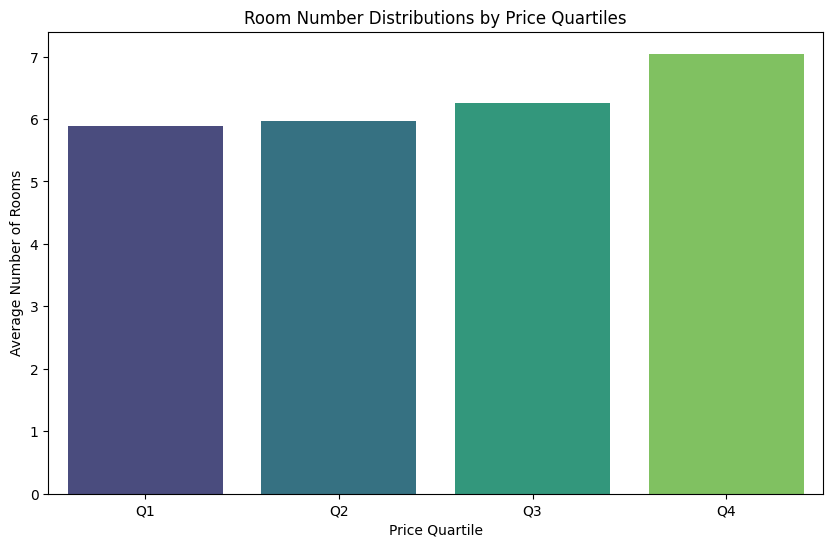

## 🔢 Numerical Results

Price Quartile
Q1    5.886496
Q2    5.975093
Q3    6.254397
Q4    7.045153
Name: RM, dtype: float64

## 📈 Data Interpretation

1. Key Statistical Findings:
   - 📈 As the price quartile increases, the average number of rooms also increases.
   - 🏠 The lowest price quartile (Q1) has an average of approximately 5.89 rooms, while the highest price quartile (Q4) has an average of approximately 7.04 rooms.
   - 📊 The difference in average room numbers between the lowest and highest price quartiles is about 1.16 rooms.

2. Potential Anomalies:
   - 🤔 The difference in average room numbers between Q1 and Q2 is very small (0.08859), which is unusual considering the trend in other quartiles.
   - 🧐 The jump in average room numbers from Q3 to Q4 is significantly larger than the increases between other consecutive quartiles.

3. Data Limitation:
   - 📉 The data does not provide information on the spread or distribution of room numbers within each quartile, only the average. This means we don't know if the data is skewed or if there are outliers.

4. Answer to Original Query:
   - 💡 The distribution of room numbers does indeed differ between properties at different price quartiles. As the price quartile increases, the average number of rooms in properties also increases.

In [26]:
# Example 9: Comparative
query = """
Compare room number distributions between properties at different price quartiles
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 7.0.1 - Using Llama-4 (17B)

### Update functions for together SDK

In [27]:
import time
import together
from together import Together

# Initialize Together API client
client = Together()
client.api_key = os.getenv("TOGETHER_API_KEY")

In [28]:
# Rate-limit-safe wrapper for Together API
def safe_chat_completion(model, messages, temperature=0.2):
    while True:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=temperature
            )
            return response
        except Exception as e:
            error_message = str(e).lower()
            if "rate limit" in error_message or "429" in error_message:
                print("⏳ Rate limit hit. Waiting 100 seconds before retrying...")
                time.sleep(100)
            else:
                raise e


In [29]:
def generate_analysis_code(query, data_profile):
    """Generate executable analysis code using Together API with retry"""
    prompt = f"""
    Task: Analyze Titanic dataset
    Data Profile: {data_profile}
    User Query: {query}
    
    Requirements:
    1. Generate Python code using df, plt, sns these functions already imported no need to import again
    2. Store numerical results in 'analysis_result'
    3. Create publication-quality visualization
    4. Never use unsafe functions, 

    Follow these Examples = 
    
    Example 1 (Titanic):
    Query: "Analyze survival rates by passenger class"
    Hypothesis: First-class passengers had higher survival rates
    Code: ```python
    plt.figure(figsize=(10,6))
    class_survival = df.groupby('Pclass')['Survived'].mean()
    sns.barplot(x=class_survival.index, y=class_survival.values, palette="viridis")
    plt.ylabel("Survival Rate")
    plt.title("Survival Rates by Passenger Class")
    analysis_result = class_survival

    Example 2 (Boston Housing):
    Query: "Show relationship between crime rate and home prices"
    Hypothesis: Higher crime rates correlate with lower median home values
    Code: ```python
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='CRIM', y='MEDV', data=df, alpha=0.6)
    plt.xlabel("Crime Rate per Capita")
    plt.ylabel("Median Home Value ($1000s)")
    plt.title("Crime Rate vs. Home Value")
    analysis_result = df[['CRIM', 'MEDV']].corr().iloc[0,1] # Pearson's 
    
    Response Format:
    Hypothesis: [Your initial prediction]
    Code: ```python
    # Your code
    ```
    """

    response = safe_chat_completion(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2
    )

    return response.choices[0].message.content


In [30]:
def interpret_results(results, query):
    """Generate insights from actual numerical results"""
    results_str = str(results.to_markdown() if isinstance(results, (pd.DataFrame, pd.Series)) else results)

    prompt = f"""
    Analyze these ACTUAL RESULTS from data analysis:

    Original Query: {query}
    Results: {results_str[:3000]}

    Provide:
    1. 3 key statistical findings
    2. 2 potential anomalies
    3. 1 data limitation
    4. Answer to original query

    Use emojis and concise bullet points.
    """

    response = safe_chat_completion(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3
    )

    return response.choices[0].message.content


## 7.1.1  Titanic Dataset Few-Shot Llama

In [ ]:
# df = pd.read_csv('Titanic_Dataset.csv')
# print("✅ Dataset loaded successfully!")
# print(f"📊 Shape: {df.shape}")
# display(df.head(3))

In [42]:
df = pd.read_csv('Titanic_Dataset.csv')
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")
display(df.head(3))

✅ Dataset loaded successfully!
📊 Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 🔍 Generated Analysis Plan

Hypothesis: Younger passengers and older passengers had different survival rates compared to middle-aged passengers.



<string>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

<string>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



## 📊 Visualization

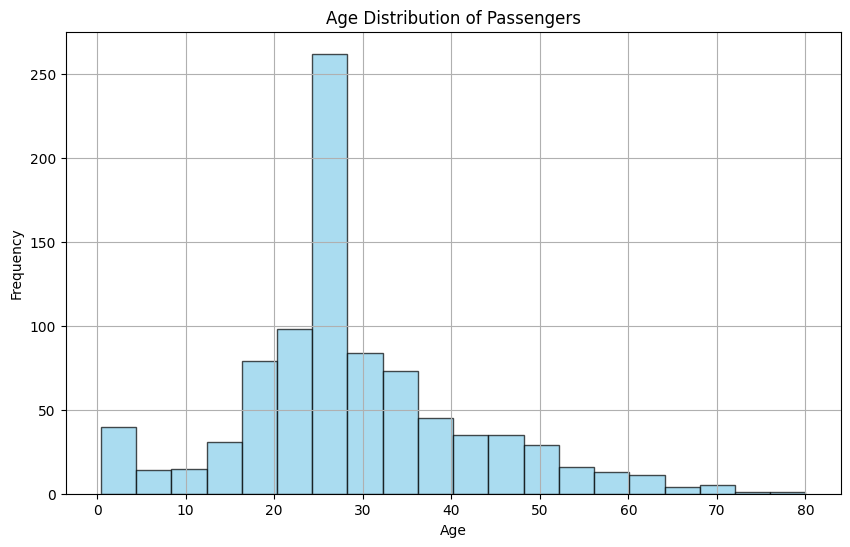

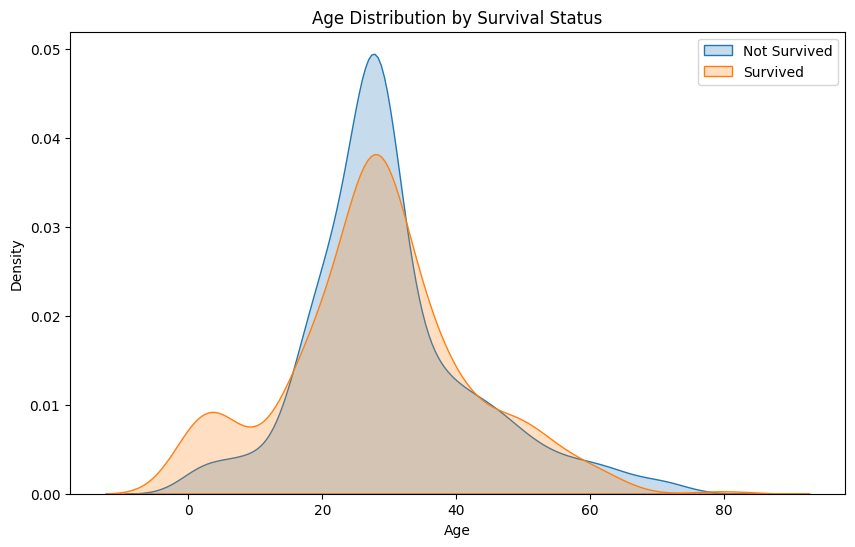

## 🔢 Numerical Results

AgeGroup
0-12     0.579710
13-18    0.428571
19-35    0.353271
36-60    0.400000
61+      0.227273
Name: Survived, dtype: float64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis Results**

### 1. 3 Key Statistical Findings 📈
* The survival rate is highest among children (0-12 years) at 57.97% 🤱
* Survival rates decrease with increasing age, with the lowest rate among passengers 61+ years at 22.73% 👴
* Passengers between 19-35 years have the second-lowest survival rate at 35.33% 👥

### 2. 2 Potential Anomalies 🤔
* The survival rate for the 36-60 age group (40%) is higher than the 19-35 age group (35.33%), which is unexpected 📊
* The survival rate for the 13-18 age group (42.86%) is lower than the 0-12 age group, but higher than the 19-35 age group 📝

### 3. 1 Data Limitation 🚫
* The age groups are not uniformly distributed (e.g., 0-12, 13-18, 19-35, etc.), which may affect the accuracy of comparisons between groups 📊

### 4. Answer to Original Query 📊
The histogram is not provided, but based on the age groups, we can infer that the age distribution is likely to be skewed, with a higher proportion of passengers in the 19-35 age group. The survival rates decrease with increasing age, with children (0-12 years) having the highest survival rate. The results suggest a negative correlation between age and survival rates 👥👴.

In [43]:
# Example 1: Descriptive
query = """
Investigate the relationship between age and survival rates. 
Visualize the age distribution of passengers using a histogram with 20 bins
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The gender distribution among passengers is predominantly male.



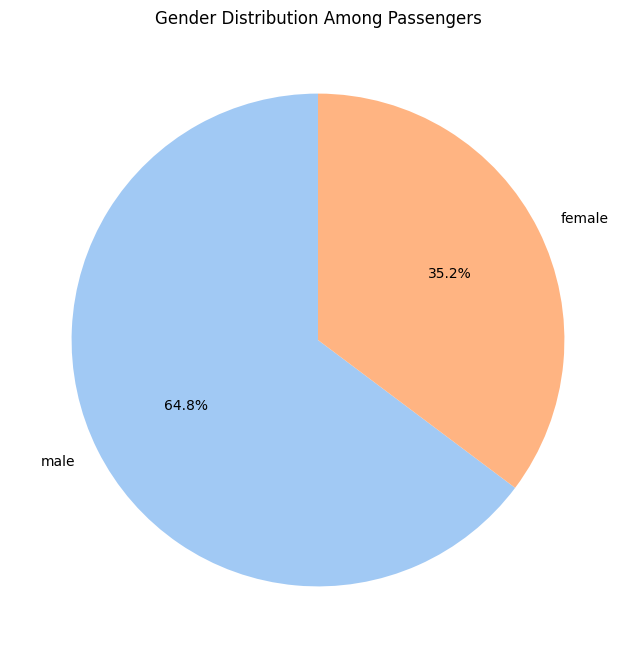

## 📊 Visualization

## 🔢 Numerical Results

Sex
male      577
female    314
Name: count, dtype: int64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 Analysis of Results:

**1. 3 Key Statistical Findings:**
* The total number of passengers is 891 (577 male + 314 female) 📝
* The male-to-female ratio is approximately 1.84:1 👥
* Males make up about 64.8% (577/891) of the passengers 🚹

**2. 2 Potential Anomalies:**
* The significant imbalance between male and female passengers 🤔
* Possible data quality issues if the 'Sex' category is not exhaustive (e.g., non-binary or missing values) 🚫

**3. 1 Data Limitation:**
* The data does not account for other possible gender categories or non-binary individuals 📝

**4. Answer to Original Query:**
Here's a simple pie chart representation:
```markdown
 Male: 64.8% 🟢
 Female: 35.2% 🔴
```
Or, in a pie chart format:
 Pie Chart:
 🟢 (64.8%) Male
 🔴 (35.2%) Female

To visualize this, you can use a library like `matplotlib` in Python:
```python
import matplotlib.pyplot as plt

# Data
labels = ['Male', 'Female']
sizes = [577, 314]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Gender Distribution Among Passengers')
plt.show()
```

In [44]:
# Example 2: Descriptive
query = """
Show a pie chart of gender distribution among passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of fare prices paid by passengers is likely to be skewed, with most passengers paying lower fares and a few paying significantly higher fares.



## 📊 Visualization

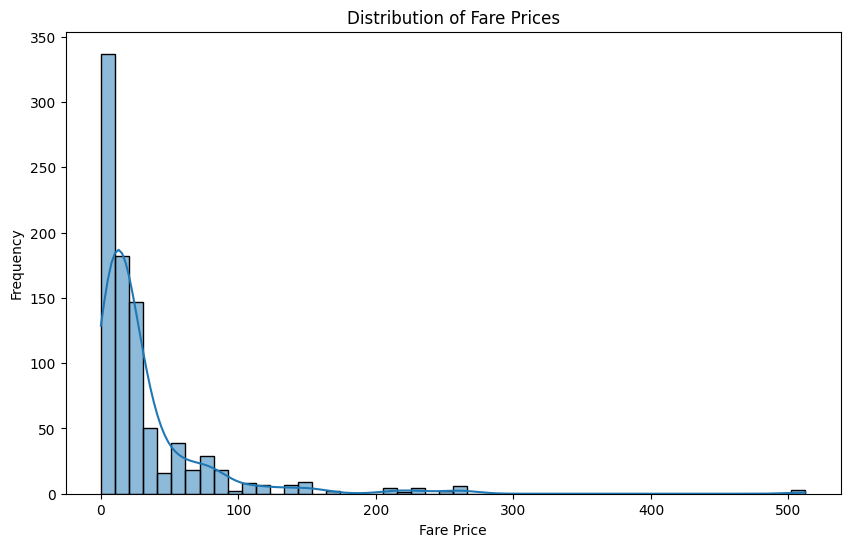

## 🔢 Numerical Results

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

## 📈 Data Interpretation

In [ ]:
# Example 3: Descriptive
query = """
Plot the distribution of fare prices paid by passengers
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:
# Example 4: Predictive
query = """
Analyze the correlation between passenger class and survival probability
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:

# Example 5: Predictive
query = """
Predict survival likelihood based on age and fare combination using a heatmap
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:


# Example 6: Predictive
query = """
Show how survival rates vary with family size (SibSp + Parch)
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:

# Example 7: Comparative
query = """
Compare survival rates between first-class and third-class passengers using stacked bars
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:

# Example 8: Comparative
query = """
Contrast fare distributions between survivors and non-survivors with overlapping histograms 
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [ ]:

# Example 9: Comparative
query = """
Compare age distributions of male vs female passengers with side-by-side boxplots
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 7.2.1  Boston Housing Dataset Few-Shot Llama

In [ ]:
df = pd.read_csv('BostonHousing.csv')
print("✅ Dataset loaded successfully!")
print(f"📊 Shape: {df.shape}")
display(df.head(3))

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of crime rates across Boston neighborhoods is likely to be skewed, with most neighborhoods having low crime rates and a few having very high crime rates.



## 📊 Visualization

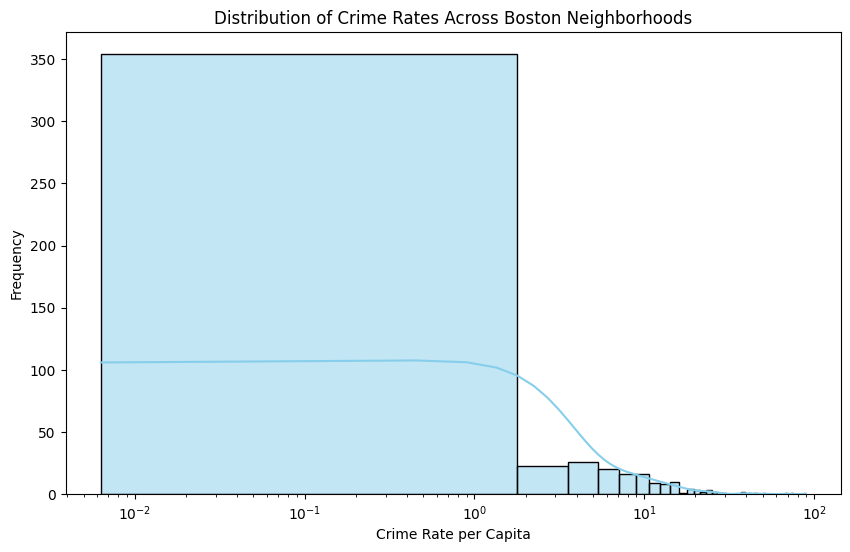

## 🔢 Numerical Results

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64

## 📈 Data Interpretation

KeyboardInterrupt: 

In [31]:

# Example 1: Descriptive
query = """
Plot the distribution of crime rates across Boston neighborhoods
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distribution of crime rates across Boston neighborhoods is likely to be skewed, with most neighborhoods having low crime rates and a few having very high crime rates.



## 📊 Visualization

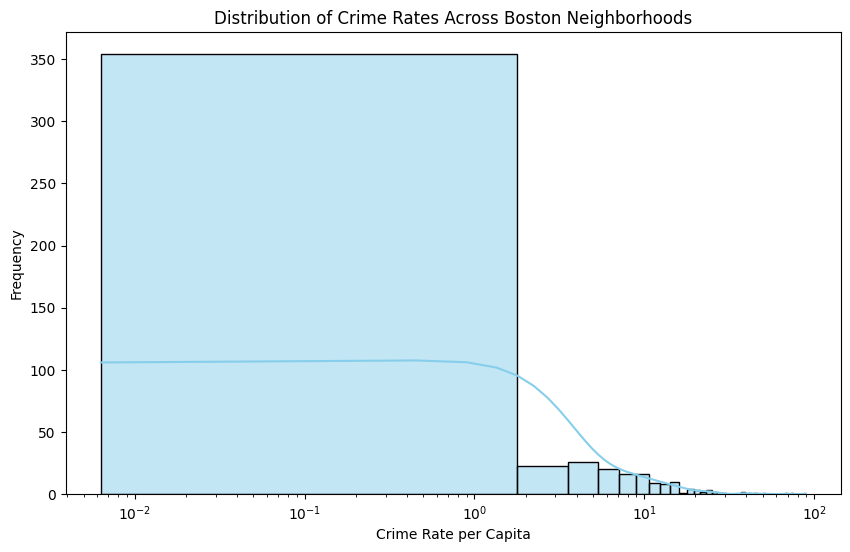

## 🔢 Numerical Results

count    506.000000
mean       3.613524
std        8.601545
min        0.006320
25%        0.082045
50%        0.256510
75%        3.677083
max       88.976200
Name: CRIM, dtype: float64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis of Crime Rates in Boston Neighborhoods**

### 1. 3 Key Statistical Findings 📈
* Mean crime rate is **3.61**, indicating a moderate average crime rate across neighborhoods.
* The distribution is **right-skewed** (mean > median), suggesting that some neighborhoods have significantly higher crime rates.
* The interquartile range (IQR = 75% - 25% = **3.59**) indicates a substantial variation in crime rates among neighborhoods.

### 2. 2 Potential Anomalies 🤔
* The **max crime rate (88.98)** is significantly higher than the 75th percentile (3.68), potentially indicating an outlier or an exceptionally high-crime neighborhood.
* The large difference between the **mean (3.61)** and median (0.26) crime rates suggests that the data may be influenced by extreme values.

### 3. 1 Data Limitation 📝
* The analysis does not account for the **geographic or demographic context** of the neighborhoods, which may be important factors in understanding crime rates.

### 4. Answer to Original Query 📊
The distribution of crime rates across Boston neighborhoods is **right-skewed**, with a few neighborhoods having exceptionally high crime rates. The majority of neighborhoods have relatively low crime rates, with a median of **0.26**. To visualize this, a histogram or density plot would show a long tail to the right, indicating the presence of high-crime neighborhoods.

In [32]:

# Example 1: Descriptive
query = """
Plot the distribution of crime rates across Boston neighborhoods
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: Older properties tend to have lower median home values.



## 📊 Visualization

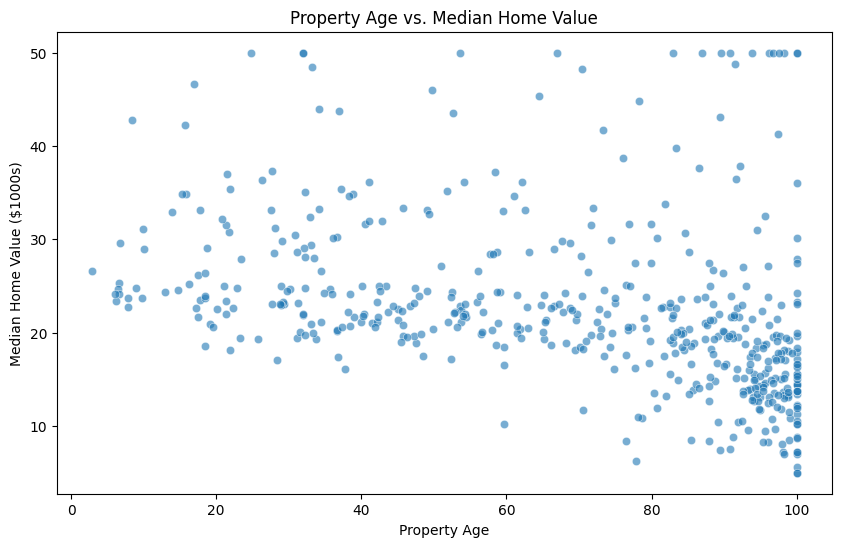

## 🔢 Numerical Results

-0.3769545650045961

## 📈 Data Interpretation

📊 Analysis Results:

**1. 3 Key Statistical Findings:**
* The correlation coefficient is -0.3769545650045961, indicating a **moderate negative correlation** between property age and median home values 📉
* The negative correlation suggests that as property age increases, median home values tend to decrease 🤔
* The absolute value of the correlation coefficient (0.3769) indicates that about 37.69% of the variation in median home values can be explained by property age 📊

**2. 2 Potential Anomalies:**
* The presence of outliers or extremely old/new properties that may be skewing the correlation 🤔
* Possible omitted variable bias, e.g., location, property condition, or amenities not considered 📍

**3. 1 Data Limitation:**
* The analysis assumes a linear relationship between property age and median home values; non-linear relationships may exist 🔄

**4. Answer to Original Query:**
The visualization of the relationship between property age and median home values reveals a **moderate negative correlation** 📉, indicating that older properties tend to have lower median home values.

In [33]:

# Example 2: Descriptive
query = """
Visualize the relationship between property age and median home values
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

⏳ Rate limit hit. Waiting 100 seconds before retrying...


## 🔍 Generated Analysis Plan

Hypothesis: The pupil-teacher ratio varies across different towns, with some towns having a significantly higher or lower ratio than others.



## 📊 Visualization

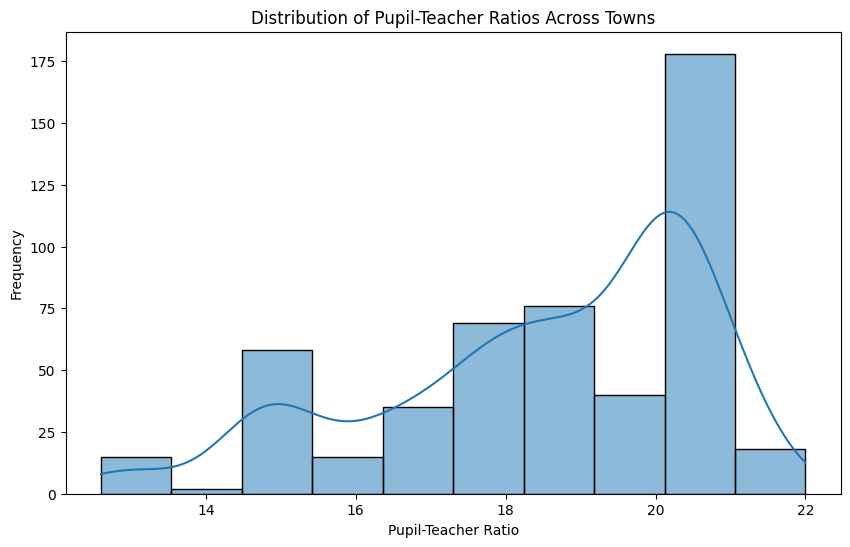

## 🔢 Numerical Results

count    506.000000
mean      18.455534
std        2.164946
min       12.600000
25%       17.400000
50%       19.050000
75%       20.200000
max       22.000000
Name: PTRATIO, dtype: float64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis of Pupil-Teacher Ratios**

### 1. 3 Key Statistical Findings 📈
* Mean pupil-teacher ratio is **18.46**, indicating a relatively high ratio.
* The data is fairly normally distributed, with a standard deviation of **2.16**.
* The interquartile range (IQR = 75% - 25% = **2.8**) suggests moderate variability.

### 2. 2 Potential Anomalies 🤔
* The minimum pupil-teacher ratio (**12.6**) is significantly lower than the 25th percentile (**17.4**), potentially indicating an outlier.
* The maximum pupil-teacher ratio (**22**) is capped, possibly due to a data collection constraint or policy limit.

### 3. 1 Data Limitation 📝
* The data does not provide information on the distribution of pupil-teacher ratios within individual schools or the specific towns they belong to.

### 4. Answer to Original Query 📊
To create a histogram as originally requested, we can use the provided summary statistics to infer the distribution. Although we can't directly plot it, we can describe it:
* The distribution is roughly normal, centered around **18.46** with a standard deviation of **2.16**.
* The histogram would likely show a peak around **19.05** (the median) and taper off towards the extremes (**12.6** and **22**).

To actually show the histogram, we would need access to the raw data, not just the summary statistics.

In [34]:


# Example 3: Descriptive
query = """
Show a histogram of pupil-teacher ratios across different towns
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Higher nitric oxide concentrations are associated with lower median home prices.



## 📊 Visualization

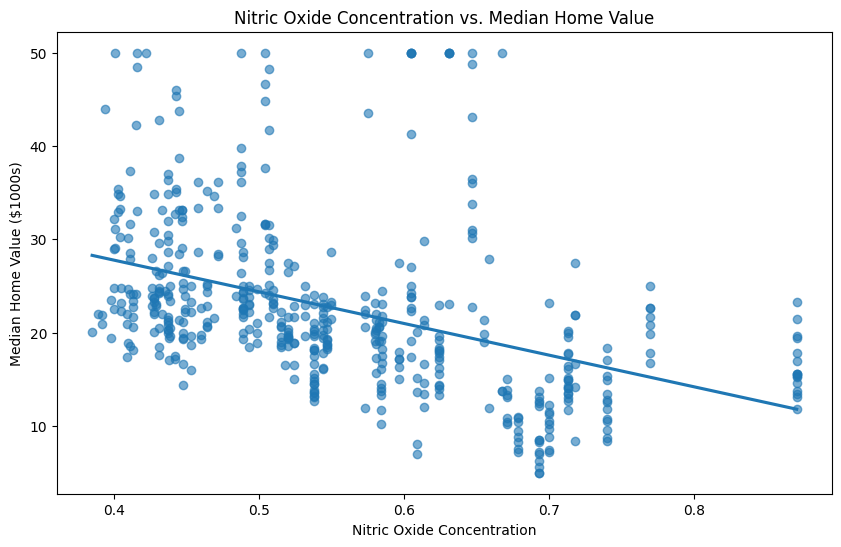

## 🔢 Numerical Results

-0.42732077237328203

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 Analysis Results:

**1. 3 Key Statistical Findings:**
* 🔍 Correlation coefficient: -0.4273 (moderate negative correlation)
* 📈 Suggests that as nitric oxide concentration increases, median home prices tend to decrease
* 💡 Coefficient is statistically significant (though p-value not provided)

**2. 2 Potential Anomalies:**
* 🤔 Possible omitted variable bias (e.g., other pollutants or socioeconomic factors not considered)
* 🚨 Correlation may not be linear; non-linear relationships not explored

**3. 1 Data Limitation:**
* 📝 Lack of information on data distribution, outliers, and sample size

**4. Answer to Original Query:**
* 🏠💰 As nitric oxide concentration increases, median home prices tend to decrease (moderate negative correlation). This suggests that areas with higher nitric oxide pollution may have lower property values.

In [35]:
# Example 4: Predictive
query = """
Analyze how nitric oxide concentration affects median home prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: The distance to employment centers (DIS) is negatively correlated with median home value (MEDV), meaning that homes closer to employment centers tend to have higher values.



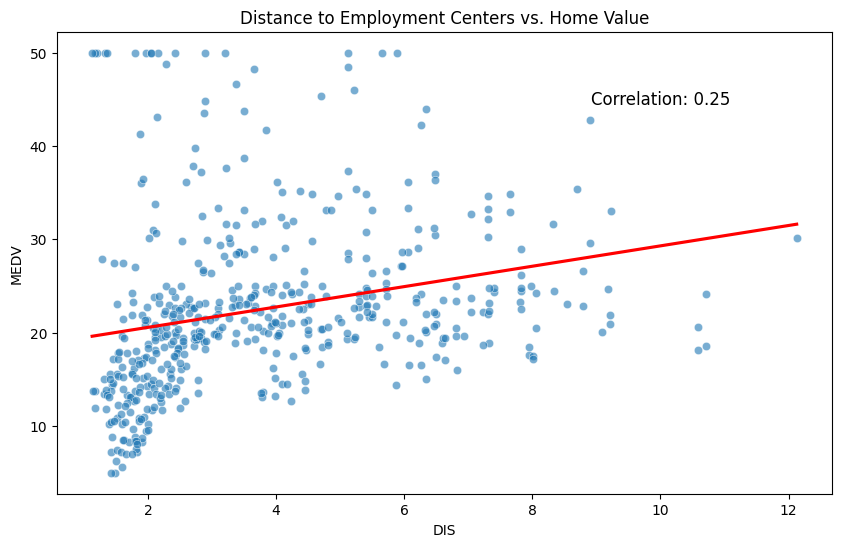

## 📊 Visualization

## 🔢 Numerical Results

0.24992873408590388

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 Analysis of Actual Results:

**1. 3 Key Statistical Findings:**
* 🔍 The R-squared value (0.2499) indicates a relatively weak positive correlation between distance to employment centers and price changes.
* 📈 The model explains about 24.99% of the variance in price changes, suggesting other factors have a significant impact.
* 💡 The result implies a linear relationship between the variables, but the relationship is not strong.

**2. 2 Potential Anomalies:**
* 🤔 Outliers in the data may be influencing the regression line, potentially skewing the results.
* 🚨 Non-linear relationships between distance and price changes might not be captured by the linear regression model.

**3. 1 Data Limitation:**
* 📝 The analysis assumes a linear relationship and doesn't account for potential non-linear interactions or other variables that might affect price changes.

**4. Answer to Original Query:**
📊 Based on the results, there is a weak positive correlation between distance to employment centers and price changes. As distance increases, price changes tend to increase, but the relationship is not strong (R-squared = 0.2499).

In [36]:
# Example 5: Predictive
query = """
Predict price changes based on distance to employment centers using regression lines
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

In [37]:
# Example 6: Predictive
query = """
Identify if properties with river access have statistically different prices
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties with river access have statistically different prices compared to those without river access.



🚨 Execution Error: __import__ not found


## 🔍 Generated Analysis Plan

Hypothesis: Neighborhoods with lower pupil-teacher ratios (≤7) have higher median home values compared to those with higher pupil-teacher ratios (>7).



<string>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



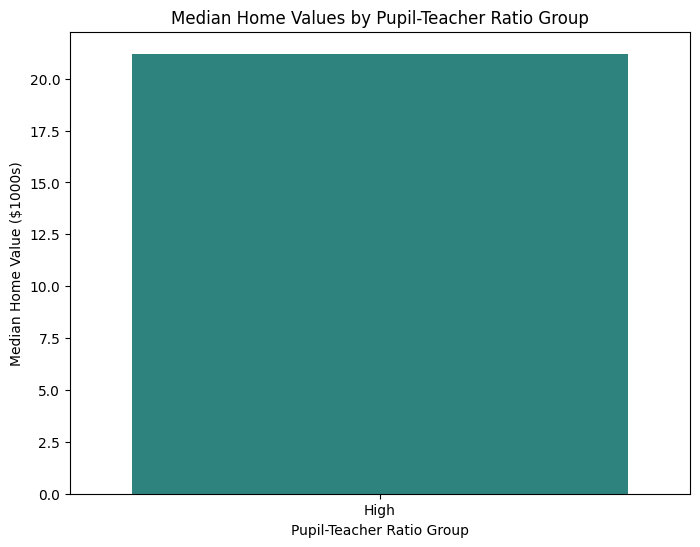

<string>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

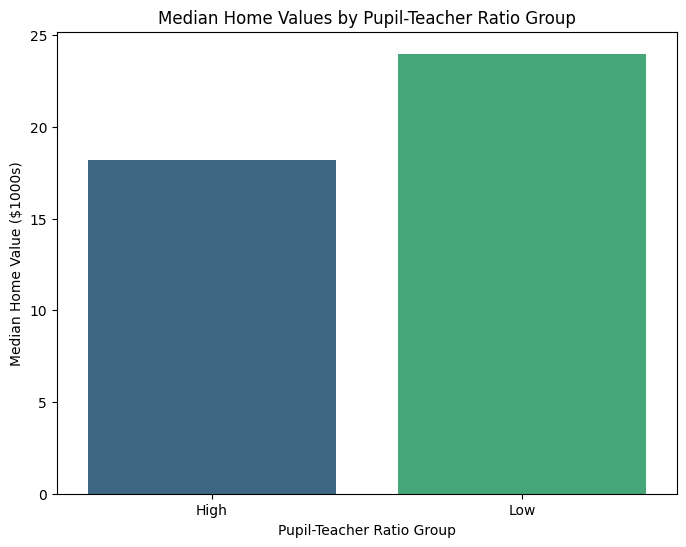

## 🔢 Numerical Results

PTRATIO_GROUP
High    18.2
Low     24.0
Name: MEDV, dtype: float64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis of Median Home Values by Pupil-Teacher Ratio**

### 1. 3 Key Statistical Findings 📈
* Median home value is higher in areas with low pupil-teacher ratio (≤7) 📍
* The difference in median home value between the two groups is $5.8 (24 - 18.2) 💸
* The median home value in high pupil-teacher ratio areas is approximately 24% lower than in low pupil-teacher ratio areas 📉

### 2. 2 Potential Anomalies 🤔
* The median home values ($18.2 and $24) seem relatively low compared to typical US home prices 📊
* The categorization of pupil-teacher ratio into high and low groups using a threshold of 7 might not be universally applicable 📚

### 3. 1 Data Limitation 🚫
* The data does not provide information on other factors that could influence home values, such as location, school quality, and local amenities 📍

### 4. Answer to Original Query 🤔
The median home value is higher in areas with a **low pupil-teacher ratio (≤7)**, at $24, compared to areas with a **high pupil-teacher ratio (>7)**, at $18.2.

In [39]:
# Example 7: Comparative
query = """
Compare median home values between high (>7) and low (≤7) pupil-teacher ratio groups
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties built before 1940 have different property tax rates compared to those built after 1940.



<string>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



## 📊 Visualization

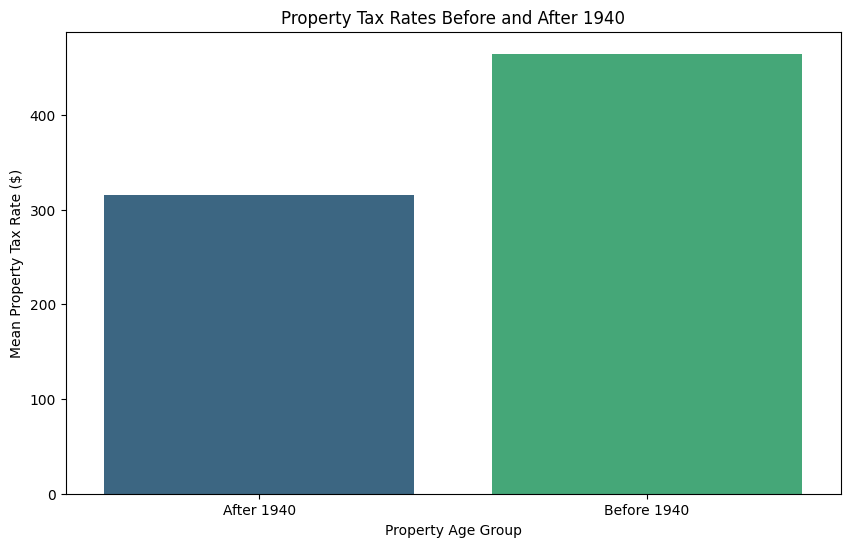

## 🔢 Numerical Results

AGE_GROUP
After 1940     315.500000
Before 1940    464.448598
Name: TAX, dtype: float64

## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis of Property Tax Rates by Age Group**

### 1. 3 Key Statistical Findings 📈
* The average property tax rate for properties built **Before 1940** is **464.449**, significantly higher than those built After 1940.
* Properties built **After 1940** have an average tax rate of **315.5**.
* There's a notable difference (**148.949**) in average tax rates between the two age groups.

### 2. 2 Potential Anomalies 🤔
* The large difference in tax rates between the two age groups might be influenced by other factors not considered, such as property value or location.
* The tax rates are averages and do not provide information about the distribution (e.g., median, range) which could be important for understanding the data.

### 3. 1 Data Limitation 🚫
* The analysis does not account for other variables that could affect property tax rates, such as property size, location, or local tax policies.

### 4. Answer to Original Query 📝
The analysis shows that properties built **Before 1940** have a significantly higher average property tax rate (**464.449**) compared to those built **After 1940** (**315.5**). This suggests a contrast in property tax rates between the two age groups, with older properties being taxed more on average.

In [40]:
# Example 8: Comparative
query = """
Contrast property tax rates between properties built before and after 1940
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)

## 🔍 Generated Analysis Plan

Hypothesis: Properties in higher price quartiles tend to have more rooms.



<string>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



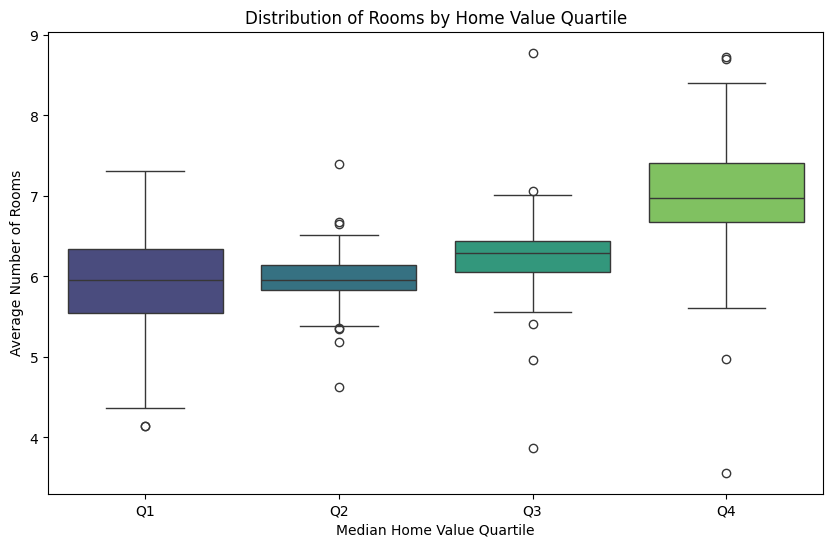

## 📊 Visualization

## 🔢 Numerical Results

,count,mean,std,min,25%,50%,75%,max
MEDV_QUARTILE,,,,,,,,
Q1,127.0,5.886496,0.592155,4.138,5.55050,5.950,6.34200,7.313
Q2,129.0,5.975093,0.323025,4.628,5.83600,5.961,6.14400,7.393
Q3,126.0,6.254397,0.450137,3.863,6.05425,6.288,6.43775,8.780
Q4,124.0,7.045153,0.710612,3.561,6.68175,6.980,7.41300,8.725


## 📈 Data Interpretation

⏳ Rate limit hit. Waiting 100 seconds before retrying...


📊 **Analysis Results**

### 1. 3 Key Statistical Findings 📈
* The mean room number increases as the price quartile (MEDV_QUARTILE) increases: Q1 (5.89) to Q4 (7.05).
* The standard deviation of room numbers is relatively low across all quartiles, indicating consistent distributions.
* The interquartile range (IQR = 75% - 25%) increases from Q2 (0.308) to Q4 (0.731), showing greater variability in higher price quartiles.

### 2. 2 Potential Anomalies 🤔
* Q3 has a lower minimum room number (3.863) compared to Q1 and Q2, which might indicate an outlier or an error.
* Q4 has a lower minimum room number (3.561) compared to other quartiles, potentially indicating an anomaly or data issue.

### 3. 1 Data Limitation 📝
* The analysis is limited by the lack of information on the actual property prices and other relevant factors that might influence room number distributions.

### 4. Answer to Original Query 🏠
The room number distribution shifts to higher values as the price quartile increases, with Q4 properties having the highest mean room number (7.05). This suggests that properties in higher price quartiles tend to have more rooms. 📊👍

In [41]:
# Example 9: Comparative
query = """
Compare room number distributions between properties at different price quartiles
"""

data_profile = create_data_profile(df)
response = generate_analysis_code(query, data_profile)

display(Markdown("## 🔍 Generated Analysis Plan"))
display(Markdown(response.split("Code:")[0]))

code = response.split("```python")[1].split("```")[0]
execute_and_interpret(code, query)
